# Анализ поведения пользователей приложения по продаже продуктов питания

### Оглавление
<ul>
    <li><a href="#Описание проекта">Описание проекта</a></li>
    <li><a href="#1. Предобработка данных ">1. Предобработка данных </a></li>
    <ul>
        <li><a href="#1. Предобработка данных. Промежуточный вывод">Промежуточный вывод </a></li>
    </ul> 
    <li><a href="#2. Исследовательский анализ данных">2. Исследовательский анализ данных</a></li>
    <ul>
        <li><a href="#2. Исследовательский анализ. Промежуточный вывод">Промежуточный вывод </a></li>
    </ul> 
    <li><a href="#3. Анализ воронки событий">3. Анализ воронки событий</a></li>
    <ul>
        <li><a href="#3. Анализ воронки событий. Промежуточный вывод">Промежуточный вывод </a></li>
    </ul> 
    <li><a href="#4. Анализ результатов A/A/B теста">4. Анализ результатов A/A/B теста</a></li>
    <ul>
        <li><a href="#Анализ результатов A/A теста">Анализ результатов A/A теста </a></li>
        <li><a href="#Анализ результатов A/B теста">Анализ результатов A/B теста </a></li>
        <li><a href="#4. Анализ результатов A/A/B теста. Промежуточный вывод">Промежуточный вывод </a></li>
    </ul> 
    <li><a href="#Общий вывод">Общий вывод</a></li>

    


<a id="Описание проекта"></a>
## Описание проекта

В рамках проекта изучим поведение пользователей мобильного приложения стартапа по продаже проудктов питания. Проанализируем воронку продаж, а также исследуем результаты A/A/B тестирования, запущенного с целью проверки влияния замены шрифтов в приложении на конверсию пользователей.

Исследование будет содержать следующие шаги:

1. Выгрузка и предобработка данных 
2. Исследовательский анализ данных
3. Анализ воронки событий
4. Анализ результатов A/A/B теста.


Выгрузим необходимые библиотеки:

In [2]:
import pandas as pd
from datetime import datetime as dt
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np

from scipy import stats as st
import math as mth

<a id="1. Предобработка данных"></a>
## 1. Предобработка данных 

In [3]:
try:
    logs= pd.read_csv('/Users/kristinabalcugova/Documents/logs_exp.csv',sep='\t')
except: 
    logs= pd.read_csv('/datasets/logs_exp.csv',sep='\t')

In [4]:
display(logs.head())
logs.info()



,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


В нашем распоряжении - датасет logs, которые содержит следующие данные:

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события в формате unix;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

Всего в датасете 244126 записей, пропущенных значений нет. В рамках предобработки данных: 
- переименуем столбцы, 
- проверим датасет на наличие дубликатов, 
- добавим столбцы со значением даты, а также даты и времени события.


In [5]:
# переименуем столбцы датасета

logs = logs.rename(columns={'EventName':'event_name','DeviceIDHash':'device_id_hash','EventTimestamp':'event_timestamp','ExpId':'exp_id'})
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       244126 non-null  object
 1   device_id_hash   244126 non-null  int64 
 2   event_timestamp  244126 non-null  int64 
 3   exp_id           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [6]:
# проверим датасет на наличие дубликатов

print('Количество строк-дубликтов:',logs.duplicated().sum())
print('Доля строк-дубликатов от общего объема датасета:', round(logs.duplicated().sum() / len(logs),3))

Количество строк-дубликтов: 413
Доля строк-дубликатов от общего объема датасета: 0.002


В датасете обнаружено 413 дубликтов, это 0,2% от общего числа строк. Удалим их во избежание искажения результатов.

In [7]:
logs = logs.drop_duplicates().reset_index(drop=True)
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   event_name       243713 non-null  object
 1   device_id_hash   243713 non-null  int64 
 2   event_timestamp  243713 non-null  int64 
 3   exp_id           243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.4+ MB


Проверим, нет ли в датасете пользователей, которые были отнесены к более чем одной группе.

In [8]:
print(
    'Макисмальное количество групп, к которым был отнесен один пользователь:',
    logs.groupby('device_id_hash', as_index=False).agg({'exp_id':'nunique'})['exp_id'].max()
)
    

Макисмальное количество групп, к которым был отнесен один пользователь: 1


Столбец event_timestamp содержит данные о времени события в формате unix. Извлечем значения даты, а также даты и времени события из этого столбца и сохраним их в столбцах date и date_time соответственно.

In [9]:
logs['date_time'] = pd.to_datetime(logs['event_timestamp'], unit='s')
logs['date'] = pd.to_datetime(logs['date_time'].apply(lambda x: x.date()))

display(logs.head())
logs.info()

,event_name,device_id_hash,event_timestamp,exp_id,date_time,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  int64         
 3   exp_id           243713 non-null  int64         
 4   date_time        243713 non-null  datetime64[ns]
 5   date             243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


<a id="1. Предобработка данных. Промежуточный вывод"></a>
### Промежуточный вывод

Мы подготовили данные к анализу:

- убедились в отсутствии пропущенных значений, 
- переименовали столбцы, 
- удалили 413 дубликатов (0,02% от общего объема датасета); 
- создали столбцы date и date_time, которые содержат значения даты и даты и времени событий соответственно в формате date_time.

<a id="2. Исследовательский анализ данных"></a>
## 2. Исследовательский анализ данных

Выведем на экран общую информацию о данных в логе:

In [10]:
print('Всего событий в логе:', len(logs))
print('Всего пользователей в логе:', len(logs['device_id_hash'].unique()))
print ('Среднее число событий на одного пользователя:',round(len(logs)/len(logs['device_id_hash'].unique())))
print('В логе представлены события за период с',logs['date'].min(),'по',logs['date'].max())

Всего событий в логе: 243713
Всего пользователей в логе: 7551
Среднее число событий на одного пользователя: 32
В логе представлены события за период с 2019-07-25 00:00:00 по 2019-08-07 00:00:00


Text(0.5, 1.0, 'Группа 246')

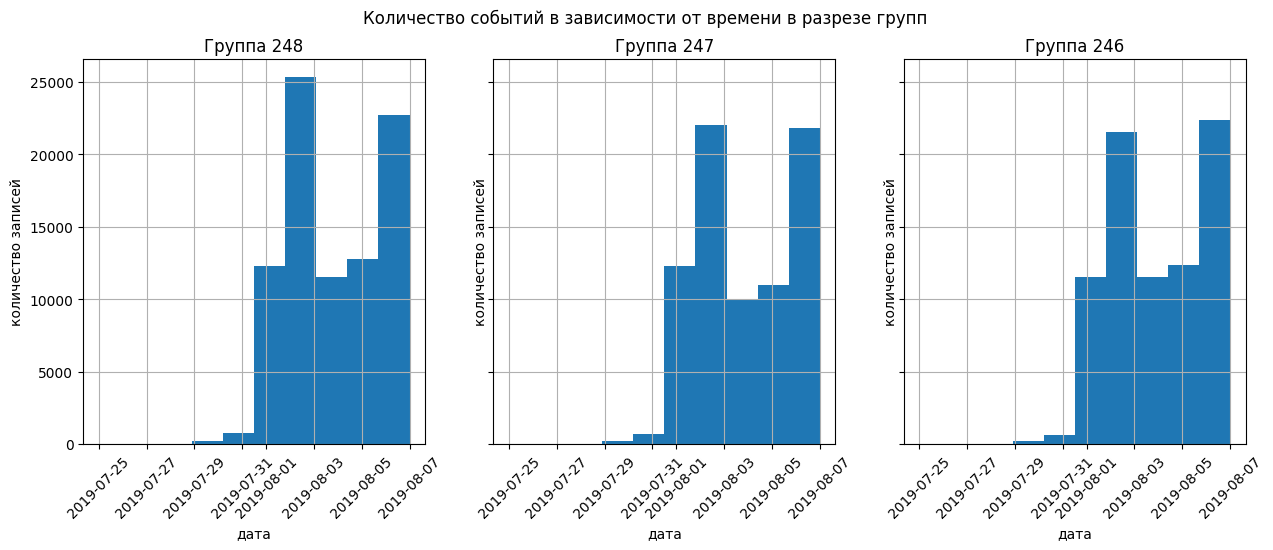

In [11]:

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15, 5), sharey=True)

fig.suptitle('Количество событий в зависимости от времени в разрезе групп')



ax1.hist(logs.query('exp_id==248')['date'])
ax1.xaxis.set_tick_params( rotation=45)
ax1.set_xlabel('дата')
ax1.set_ylabel('количество записей')
ax1.grid()
ax1.set_title('Группа 248')


ax2.hist(logs.query('exp_id==247')['date'])
ax2.xaxis.set_tick_params( rotation=45)
ax2.set_xlabel('дата')
ax2.set_ylabel('количество записей')
ax2.grid()
ax2.set_title('Группа 247')

ax3.hist(logs.query('exp_id==246')['date'])
ax3.xaxis.set_tick_params( rotation=45)
ax3.set_xlabel('дата')
ax3.set_ylabel('количество записей')
ax3.grid()
ax3.set_title('Группа 246')

Видим, что до 01.08.2019 записи по всем группам практически отсутствуют. Судя по графикам, реальный период времени, для которого предоставлены данные - с 01.08.2019 по 07.08.2019. Отбросим записи о событиях, не вошедших в этот период. Изучим, как изменились характеристики датасета после исключения неактуальных данных.

In [23]:
actual_logs = logs.query('date >= "2019-08-01"')
print('Всего событий в логе за актуальный период:', len(actual_logs))
print('Всего пользователей в логе за актуальный период:', len(actual_logs['device_id_hash'].unique()))
print ('Среднее число событий на одного пользователя за актуальный период:',round(len(actual_logs)/len(actual_logs['device_id_hash'].unique())))


Всего событий в логе за актуальный период: 240887
Всего пользователей в логе за актуальный период: 7534
Среднее число событий на одного пользователя за актуальный период: 32


In [24]:
print('Количество событий, утерянных после фильтрации:', (len(logs) - len(actual_logs)))
print('Доля событий, утерянных после фильтрации:', round((len(logs) - len(actual_logs)) / len(logs) * 100, 2), '%')
print('Количество уникальных пользователей, утерянных после фильтрации:', len(logs['device_id_hash'].unique()) - len(actual_logs['device_id_hash'].unique()))
print('Доля уникальных пользователей, утерянных после фильтрации:', round((len(logs['device_id_hash'].unique()) - len(actual_logs['device_id_hash'].unique())) /len(logs['device_id_hash'].unique()) *100,2) , '%')

Количество событий, утерянных после фильтрации: 2826
Доля событий, утерянных после фильтрации: 1.16 %
Количество уникальных пользователей, утерянных после фильтрации: 17
Доля уникальных пользователей, утерянных после фильтрации: 0.23 %


Среднее число событий на пользователя не изменилось, а доля утерянных данных составила 1%. В новый датасет не вошли данные 17ти пользователей. Проверим, сохранились ли данные о пользователях из всех трех групп A/A/B теста.

In [12]:
actual_logs_grouped = actual_logs.groupby(
    'exp_id',as_index=False).agg(
    {'device_id_hash':'nunique'})

actual_logs_grouped ['group_share'] = (
    round(actual_logs_grouped['device_id_hash']/actual_logs_grouped['device_id_hash'].sum() *100,2)
)
actual_logs_grouped = actual_logs_grouped.rename(columns={'device_id_hash':'users_count'})
actual_logs_grouped

,exp_id,users_count,group_share
0,246,2484,32.97
1,247,2513,33.36
2,248,2537,33.67


В обновленном датасете содержатся записи пользователей из трех групп в приблизительно равном соотношении. Датасет actual_logs можно использовать для дальнейшего анализа.

<a id="2. Исследовательский анализ. Промежуточный вывод"></a>
### Промежуточный вывод

Мы изучили данные и выяснили, что несмотря на то, что самая ранняя запись в исходном датасете датируется 25 июля 2019 года, реальный рассматриваемый период - с 01.08.2019 по 07.08.2019 включительно. Отсеяв записи, не относящиеся к актуальному периоду (1,2% данных), мы получили следующие характеристики данных:

- всего в логе 240887 записей;
- количество уникальных пользователей -  7534; 
- в среднем за выбранный период на одного пользователя приходится 32 события; 
- в обновленном датасете содержатся записи пользователей из трех групп теста в приблизительно равном соотношении.

<a id="3. Анализ воронки событий"></a>
## 3. Анализ воронки событий

Выведем список уникальных событий в датасете по частоте встречаемости.

In [13]:
logs_by_event_frequency = (
    actual_logs
    .groupby('event_name',as_index = False)
    .agg({'device_id_hash':'count'})
    .sort_values(by='device_id_hash',ascending=False)
).reset_index(drop=True)

logs_by_event_frequency.columns =  ['event_name','device_id_hash']
logs_by_event_frequency



,event_name,device_id_hash
0,MainScreenAppear,117328
1,OffersScreenAppear,46333
2,CartScreenAppear,42303
3,PaymentScreenSuccessful,33918
4,Tutorial,1005


Всего насчитывается пять событий, самое частотное - MainScreenAppear(пользователь открыл главный экран), далее по порядку идут OffersScreenAppear(пользователь открыл страницу с предложениями), CartScreenAppear(пользователь зашел в корзину), PaymentScreenSuccessful(пользователь успешно оплатил заказ). Реже всего пользователи совершают событие Tutorial (пользователь прошел обучение). 

Посмотрим, как много пользователей совершили каждое из событий. 

In [14]:
logs_by_user_count = (
    actual_logs
    .groupby('event_name',as_index = False)
    .agg({'device_id_hash':'nunique'})
    .sort_values(by='device_id_hash',ascending=False)
).reset_index(drop=True)

logs_by_user_count.columns =  ['event_name','user_count']
logs_by_user_count['user_share'] = round(logs_by_user_count['user_count']/len(actual_logs['device_id_hash'].unique())*100,2)

logs_by_user_count

,event_name,user_count,user_share
0,MainScreenAppear,7419,98.47
1,OffersScreenAppear,4593,60.96
2,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97
4,Tutorial,840,11.15


98,5% пользователей заходили на главный экран, 60,1% - открывали страницу с предложениями, 49,6% зашли в корзину и 47% оплатили заказ. Обучение проходили лишь 11,2% пользователей. 
Построим воронку событий на основе первых четырех этапов. Событие Tutorial в воронку включать не будем - этап обучения не является обязательным для оформления заказа, и пользователи могут открывать эту страницу на любом этапе воронки.

In [15]:
logs_by_user_count = logs_by_user_count.drop(index=4)

In [16]:
logs_by_user_count['relevant_user_share'] = round(logs_by_user_count['user_count']/logs_by_user_count['user_count'].shift(1)*100,2)
logs_by_user_count['relevant_user_loss'] = 100 - logs_by_user_count['relevant_user_share'] 
logs_by_user_count


,event_name,user_count,user_share,relevant_user_share,relevant_user_loss
0,MainScreenAppear,7419,98.47,NaN,NaN
1,OffersScreenAppear,4593,60.96,61.91,38.09
2,CartScreenAppear,3734,49.56,81.30,18.70
3,PaymentScreenSuccessful,3539,46.97,94.78,5.22


Text(0.5, 1.0, 'Воронка событий')

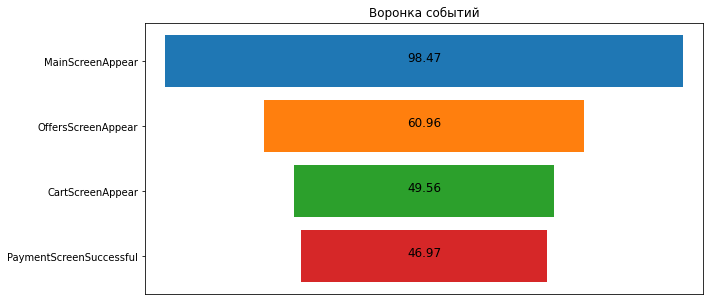

In [17]:
plt.figure(figsize=(10,5))

x = logs_by_user_count['user_count']
y = logs_by_user_count['event_name']

x_max = 8000
x_min = 0

for idx, val in enumerate(x):
    left = (x_max - val)/2
    plt.barh(y[idx], x[idx], left = left)
    plt.text(4000, y[idx], logs_by_user_count['user_share'][idx], ha='center',
             fontsize=12)
plt.xlim(x_min, x_max)
plt.gca().invert_yaxis()
ax = plt.gca ()
ax.get_xaxis ().set_visible ( False )
plt.title('Воронка событий')

In [18]:
print('Доля пользователей, которые доходят от первого события до оплаты:', 
      round(logs_by_user_count.iloc[3]['user_count']/logs_by_user_count.iloc[0]['user_count']*100,2),'%')




Доля пользователей, которые доходят от первого события до оплаты: 47.7 %


Больше всего пользователей теряется на этапе перехода с главного экрана к каталогу - почти 40% не доходят до этого этапа. Возможно, проблема - в неудобном интерфейсе приложения, который затрудняет переход пользователей к каталогу. При этом 80% пользователей, который открыли каталог, перешли в корзину; 95% пользователей, открывших корзину, успешно оформили заказ. 

Конверсия пользователей, открывших приложение, в совершивших покупку, составила 47,7%.

<a id="3. Анализ воронки событий. Промежуточный вывод"></a>
### Промежуточный вывод

Воронка событий за исследуемый период выглядит следующим образом:

1. Пользователь открыл главный экран приложения - 98,5% от общего числа пользователей совершили это событие;
2. Пользователь открыл каталог - 60,1% пользователей; 
3. Пользователь открыл корзину - 49,6%;
4. Пользователь оплатил заказ - 47%.

Больше всего пользователей теряется на этапе перехода с главного экрана к каталогу - почти 40% не доходят до этого этапа. 

47,7% пользователей, открывших главный экран приложения, успешно оплатили заказ.


<a id="4. Анализ результатов A/A/B теста"></a>
## 4. Анализ результатов A/A/B теста

Выведем на экран таблицу с количеством пользователей в каждой группе теста. Построим воронку конверсии для каждой группы в отдельности.

In [19]:
actual_logs.groupby('exp_id').agg({'device_id_hash':'nunique'})


,device_id_hash
exp_id,
246,2484
247,2513
248,2537


In [20]:
def funnel_conversion_by_group(n):
    
    print('Воронка конверсии для группы', n)
    funnel_conversion_by_group = actual_logs.query('exp_id == @n & event_name != "Tutorial"').groupby('event_name',as_index = False).agg({'device_id_hash':'nunique'}).sort_values(by='device_id_hash',ascending=False).reset_index(drop=True)
    funnel_conversion_by_group.columns =  ['event_name','user_count']
    funnel_conversion_by_group['user_share'] = round(funnel_conversion_by_group['user_count']/len(actual_logs.query('exp_id == @n')['device_id_hash'].unique())*100,2)
    funnel_conversion_by_group['relevant_user_share'] = round(funnel_conversion_by_group['user_count']/funnel_conversion_by_group['user_count'].shift(1)*100,2)
    funnel_conversion_by_group['relevant_user_loss'] = 100 - funnel_conversion_by_group['relevant_user_share'] 
    
    plt.figure(figsize=(10,3))

    x = funnel_conversion_by_group['user_count']
    y = funnel_conversion_by_group['event_name']

    x_max = 8000
    x_min = 0
    
    for idx, val in enumerate(x):
        left = (x_max - val)/2
        plt.barh(y[idx], x[idx], left = left)
        plt.text(4000, y[idx], funnel_conversion_by_group['user_share'][idx], ha='center',
             fontsize=12)
    plt.xlim(x_min, x_max)
    plt.gca().invert_yaxis()
    ax = plt.gca ()
    ax.get_xaxis ().set_visible ( False )
    plt.title(f'Воронка конверсии в группе {n}')
    
    return funnel_conversion_by_group


Воронка конверсии для группы 246


,event_name,user_count,user_share,relevant_user_share,relevant_user_loss
0,MainScreenAppear,2450,98.63,NaN,NaN
1,OffersScreenAppear,1542,62.08,62.94,37.06
2,CartScreenAppear,1266,50.97,82.10,17.90
3,PaymentScreenSuccessful,1200,48.31,94.79,5.21


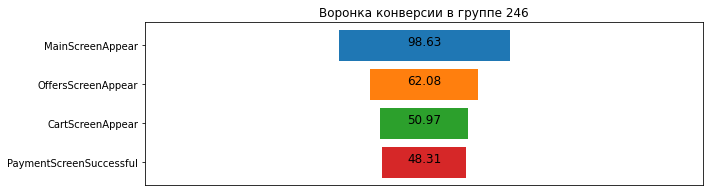

In [21]:
funnel_conversion_246 = funnel_conversion_by_group(246)
funnel_conversion_246

Воронка конверсии для группы 247


,event_name,user_count,user_share,relevant_user_share,relevant_user_loss
0,MainScreenAppear,2476,98.53,NaN,NaN
1,OffersScreenAppear,1520,60.49,61.39,38.61
2,CartScreenAppear,1238,49.26,81.45,18.55
3,PaymentScreenSuccessful,1158,46.08,93.54,6.46


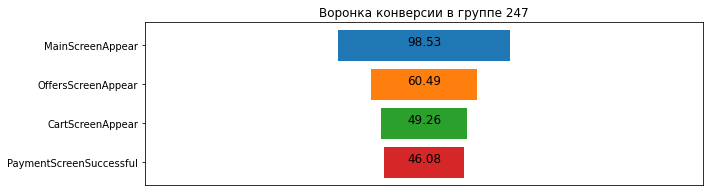

In [22]:
funnel_conversion_247 = funnel_conversion_by_group(247)
funnel_conversion_247

Воронка конверсии для группы 248


,event_name,user_count,user_share,relevant_user_share,relevant_user_loss
0,MainScreenAppear,2493,98.27,NaN,NaN
1,OffersScreenAppear,1531,60.35,61.41,38.59
2,CartScreenAppear,1230,48.48,80.34,19.66
3,PaymentScreenSuccessful,1181,46.55,96.02,3.98


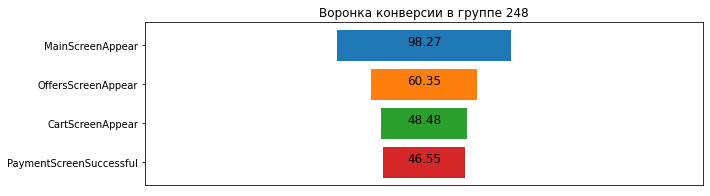

In [23]:
funnel_conversion_248 = funnel_conversion_by_group(248)
funnel_conversion_248

<a id="Анализ результатов A/A теста"></a>
### Анализ результатов A/A теста

Группы 246 и 247 - контрольные группы для А/А-эксперимента. Проверим, нет ли статистической разницы между этими выборками. Для этого создадим переменные, содержащие данные о количестве пользователей каждой из двух групп, совершавших то или иное событие в каждый из дней анализируемого периода, и проведем t-тест. 

Нулевая гипотеза: средние значения количества активных пользователей в день двух выборок не отличаются.
Альтернативная гипотеза: средние значения количества активных пользователей в день различаются, и это различие статистически значимо.

In [24]:
alpha = 0.01

a1_data = (
    list(
        actual_logs.query('exp_id==246')
        .groupby('date',as_index=False)
        .agg({'device_id_hash':'nunique'})['device_id_hash'])
)

a2_data = (
    list(
        actual_logs.query('exp_id==247')
        .groupby('date',as_index=False)
        .agg({'device_id_hash':'nunique'})['device_id_hash'])
)

results = st.ttest_ind(a1_data, a2_data)

print('p-значение:', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

p-значение: 0.30899748048237163
Не получилось отвергнуть нулевую гипотезу


Далее проверим результаты A/A-теста: выясним, существуют ли статистически значимые различия между относительными долями пользователей из контрольных групп на каждом этапе воронки. Для этого применим z-тест.

Мы будем применять z-тест к каждому из 4х этапов воронки конверсии. Кроме того, на этапе проверка результатов A/B-теста мы также будет применять z-тест к каждому из 4х этапов, сравнивая попарно группы 246 и 248, 247 и 248, а также объединенную контрльную группу (246+247) и 248. Итого в рамках множественного теста мы проверим 16 нулевых гипотез.

Чтобы снизить вероятность ложнопозитивного результата, применим к уровню статистической значимость alpha = 0.01 поправку Бонферрони.



In [25]:
bonferroni_alpha = alpha/16

Сформулируем нулевую и альтернативную гипотезы, которые будем проверять в рамках каждого из последующих тестов:

H0: Между тестируемыми долями двух выборок нет статистически значимых различий.
H1: Между тестируемыми долями двух выборок есть различия, и они статистически значимы.

In [26]:
#зададим функцию для проведения z-теста на каждом этапе воронки:

user_count_by_groups = (
    pd.pivot_table(data = actual_logs,
                  values='device_id_hash',
                  index='exp_id',
                  columns='event_name',
                  aggfunc='nunique')
)

user_count_by_groups['total_count'] = actual_logs.groupby('exp_id').agg({'device_id_hash':'nunique'})['device_id_hash']

user_count_by_groups.loc['control_groups_summed_up'] = (
    [(user_count_by_groups.iloc[0,0]+user_count_by_groups.iloc[1,0]),
     (user_count_by_groups.iloc[0,1]+user_count_by_groups.iloc[1,1]),
     (user_count_by_groups.iloc[0,2]+user_count_by_groups.iloc[1,2]),
     (user_count_by_groups.iloc[0,3]+user_count_by_groups.iloc[1,3]),
     (user_count_by_groups.iloc[0,4]+user_count_by_groups.iloc[1,4]),
     (user_count_by_groups.iloc[0,5]+user_count_by_groups.iloc[1,5])]
)


def aa_funnel_z_test(event, group1, group2):
    
    
    successes = (
        np.array(
            [user_count_by_groups.loc[group1,event], 
             user_count_by_groups.loc[group2,event]]
        )
    )
    trials = (
        np.array(
            [user_count_by_groups.loc[group1,'total_count'],
             user_count_by_groups.loc[group2,'total_count']]
    )
    )
    p1 = successes[0]/trials[0]
    p2 = successes[1]/trials[1]
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])
    difference = p1 - p2 

    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))


    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    print(f'Результаты z-теста для доли пользователей из групп {group1} и {group2}, совершивших событие {event}:')    
    print()
    print('p-значение: ', round(p_value,3))
    if p_value < bonferroni_alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
        'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )  
    print()
    print()

In [27]:
#проверим результаты A/A тестов на каждом этапе воронки, используя заданную выше функцию
for event in list(funnel_conversion_246['event_name']):
    aa_funnel_z_test(event,246,247)

Результаты z-теста для доли пользователей из групп 246 и 247, совершивших событие MainScreenAppear:

p-значение:  0.757
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп 246 и 247, совершивших событие OffersScreenAppear:

p-значение:  0.248
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп 246 и 247, совершивших событие CartScreenAppear:

p-значение:  0.229
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп 246 и 247, совершивших событие PaymentScreenSuccessful:

p-значение:  0.115
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




По результатам z-теста, относительные доли пользователей на каждом этапе воронки в группах 246 и 247 не имеют статистически значимых отличий. Нет оснований утверждать, что выборки различаются.

<a id="Анализ результатов A/B теста"></a>
### Анализ результатов A/B теста

Применим z-тест с использованием скорректированного уровня статистической значимости для попарного сравнения долей пользователей группы 248 и каждой из контрльных групп (246 и 257), а также объединенной контрольной группы, на каждом этапе воронки конверсии.

In [28]:
for event in list(funnel_conversion_246['event_name']):
    for group in [246,247,'control_groups_summed_up']:
        aa_funnel_z_test(event,group,248)

Результаты z-теста для доли пользователей из групп 246 и 248, совершивших событие MainScreenAppear:

p-значение:  0.295
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп 247 и 248, совершивших событие MainScreenAppear:

p-значение:  0.459
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп control_groups_summed_up и 248, совершивших событие MainScreenAppear:

p-значение:  0.294
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп 246 и 248, совершивших событие OffersScreenAppear:

p-значение:  0.208
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Результаты z-теста для доли пользователей из групп 247 и 248, совершивших событие OffersScreenAppear:

p-значение:  0.92
Не получилось отвергнуть нулевую гипотезу, нет оснований

<a id="4. Анализ результатов A/A/B теста. Промежуточный вывод"></a>
### Промежуточный вывод

Контрольные выборки (246 и 247) сформированы корректно и не имеют статистически значимых различий.

Результаты A/B тестов показали, статистически значимых различий между группами A и B не возникает ни на одном этапе воронки событий. Замена шрифтов в дизайне приложения никак не влияет на конверсию пользователей. 

<a id="Общий вывод"></a>
## Общий вывод

Мы изучили данные о поведении пользователей приложения, а также результаты A/A/B тестирования, запущенного с целью проверки влияния замены шрифтов в приложении на конверсию пользователей.

В ходе исследования получили следующие выводы:

- актуальный период исследования - с 01.08.2019 по 07.08.2019 включительно;
- в исследовании приняли участие 7534 пользователя, каждый из которых в среднем совершил 32 события за рассматриваемый период; 
- воронка событий включает в себя четыре этапа: открытие главного экрана приложения (соврешили 98,5% пользователей от общего числа), открытие каталога (60,1%), переход в корзину (49,6%), успешная оплата заказа (47%);
- больше всего пользователей теряется на этапе перехода с главного экрана к каталогу - почти 40% не доходят до этого этапа;
- 47,7% пользователей, открывших главный экран приложения, успешно оплатили заказ;
- A/A/B тест был проведен корректно: между контрольными группами не наблюдается статистически значмиых различий;
- Результаты A/B тестов показали, статистически значимых различий между группами A и B не возникает ни на одном этапе воронки событий. Замена шрифтов в дизайне приложения никак не влияет на конверсию пользователей.

На основании полученных выводов не можем порекомендовать внедрение новых шрифтов в дизайн приложения: нововведение не показало никаких положительных изменений в поведении пользователей. Вместо этого рекомендуем обратить внимание на доступность перехода от главного экрана к каталогу: низкая конверсия пользователей на этом этапе может свидетельствовать о наличии технических проблем и/или ошибок в интерфейсе.


